# Imports

In [1]:
!pip install quickdraw

In [2]:
!pip install scikeras

  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.8.2
    Uninstalling importlib-metadata-4.8.2:
      Successfully uninstalled importlib-metadata-4.8.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
markdown 3.3.6 requires importlib-metadata>=4.4; python_version < "3.10", but you have importlib-metadata 3.10.1 which is incompatible.


In [3]:
import os
import glob
import numpy as np
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras 

from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten,LSTM
from keras.utils import np_utils

from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

from quickdraw import QuickDrawDataGroup, QuickDrawData
from scikeras.wrappers import KerasClassifier

# Carregamento dos dados

In [4]:
#Separando as classes de desenhos
MAX_DRAWINGS = 1000

images_labels = ['bee',
  'coffee cup',
  'guitar',
  'hamburger',
  'rabbit',
  'truck',
  'umbrella',
  'crab',
  'banana',
  'airplane']

In [5]:
#carregando o grupo de desenhos 
images = list(map(lambda x: QuickDrawDataGroup(x, max_drawings=MAX_DRAWINGS), images_labels))

downloading bee from https://storage.googleapis.com/quickdraw_dataset/full/binary/bee.bin
download complete
loading bee drawings
load complete
downloading coffee cup from https://storage.googleapis.com/quickdraw_dataset/full/binary/coffee cup.bin
download complete
loading coffee cup drawings
load complete
downloading guitar from https://storage.googleapis.com/quickdraw_dataset/full/binary/guitar.bin
download complete
loading guitar drawings
load complete
downloading hamburger from https://storage.googleapis.com/quickdraw_dataset/full/binary/hamburger.bin
download complete
loading hamburger drawings
load complete
downloading rabbit from https://storage.googleapis.com/quickdraw_dataset/full/binary/rabbit.bin
download complete
loading rabbit drawings
load complete
downloading truck from https://storage.googleapis.com/quickdraw_dataset/full/binary/truck.bin
download complete
loading truck drawings
load complete
downloading umbrella from https://storage.googleapis.com/quickdraw_dataset/full

In [6]:
images_labels

['bee',
 'coffee cup',
 'guitar',
 'hamburger',
 'rabbit',
 'truck',
 'umbrella',
 'crab',
 'banana',
 'airplane']

In [7]:
class_names = ['bee','cup','guitar','hamburger','rabbit','truck','umbrella','crab','banana','airplane']

RS = 20150101

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

def download_and_load(test_split = 0.2, max_items_per_class = 10000):
  root = 'data2'
  os.mkdir('data2')
  print('downloading ...')
  base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
  for c in class_names:
    path = base+c+'.npy'
    print(path)
    urllib.request.urlretrieve(path, f'{root}/{c}.npy')
  print('loading ...')
  
  #inicializar variáveis 
  x = np.empty([0, 784])
  y = np.empty([0])

  #carregar cada arquivo de dados
  for idx, file in enumerate(class_names):
      data = np.load(f'{root}/{file}.npy')
      data = data[0: max_items_per_class, :]
      labels = np.full(data.shape[0], idx)

      x = np.concatenate((x, data), axis=0)
      y = np.append(y, labels)

  data = None
  labels = None

  #randomizar o conjunto de dados  
  permutation = np.random.permutation(y.shape[0])
  x = x[permutation, :]
  y = y[permutation]

  #remodelar e inverter as cores
  x = 255 - np.reshape(x, (x.shape[0], 28, 28))

  #separar em treinamento e teste 
  test_size  = int(x.shape[0]/100*(test_split*100))

  x_test = x[0:test_size, :]
  y_test = y[0:test_size]

  x_train = x[test_size:x.shape[0], :]
  y_train = y[test_size:y.shape[0]]
  
  print('Training Data : ', x_train.shape[0])
  print('Testing  Data : ', x_test.shape[0])
  return x_train, y_train, x_test, y_test, class_names

def scatter(x, colors):
    # Paleta de cores com seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # criando gráfico de dispersão.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    txts = []
    for i in range(10):
        
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, class_names[i], fontsize=15)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
        
def plot_tsne(X, y):
  print('calculating tsne ...')
  proj = TSNE(random_state=RS).fit_transform(X)
  scatter(proj, y)

In [8]:
x_train, y_train, x_test, y_test, class_names = download_and_load()

downloading ...
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/bee.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/cup.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/guitar.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/hamburger.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/rabbit.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/truck.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/umbrella.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/crab.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/banana.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/airplane.npy
loading ...
Training Data :  80000
Testing  Data :  20000


In [9]:
class_names

['bee',
 'cup',
 'guitar',
 'hamburger',
 'rabbit',
 'truck',
 'umbrella',
 'crab',
 'banana',
 'airplane']

# Visualização

In [ ]:
def visualize_classes():
  for i in range(0, 10):
    img_batch = x_train[y_train == i][0:10]
    img_batch = np.reshape(img_batch, (img_batch.shape[0]*img_batch.shape[1], img_batch.shape[2]))
    if i > 0:
      img = np.concatenate([img, img_batch], axis = 1)
    else:
      img = img_batch
  plt.figure(figsize=(10,20))
  plt.axis('off')
  plt.imshow(img)

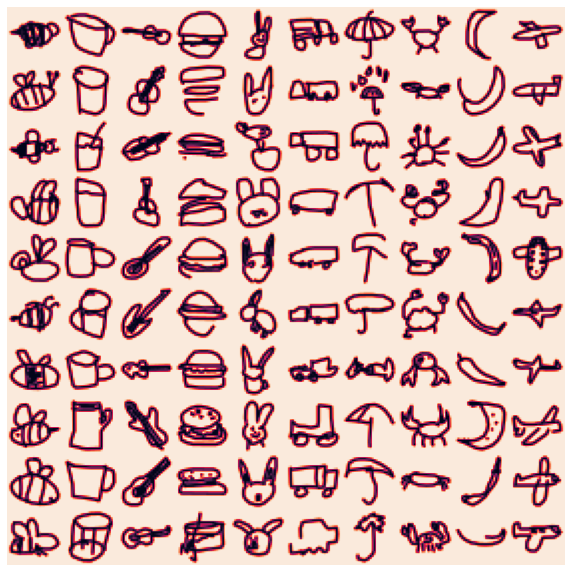

In [ ]:
#Visualização das classes

visualize_classes()

calculating tsne ...


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


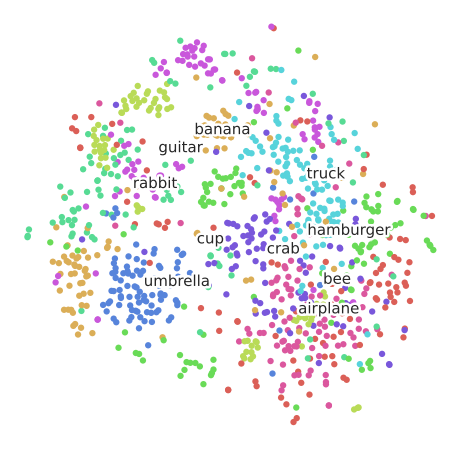

In [ ]:
#Distribuição dos Etiquetas

# Traçar uma distribuição t-sne de 1000 amostras do conjunto de treinamento
# Ele converte semelhanças entre pontos de dados em probabilidades conjuntas

X = np.reshape(x_train, (x_train.shape[0], 28 * 28))[0:1000]
y = y_train[0:1000]

plot_tsne(X, y)

# Pré-processamento

In [15]:
image_size = 28

# Remodelar e normalizar 
x_train = x_train.reshape(x_train.shape[0], image_size, image_size, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], image_size, image_size, 1).astype('float32')

x_train /= 255.0
x_test /= 255.0

# Converter vetores de classe em matrizes de classe
y_train = keras.utils.to_categorical(y_train, len(class_names))
y_test = keras.utils.to_categorical(y_test, len(class_names))

# CNN

## model_cnn

In [192]:
model_cnn = keras.Sequential()
model_cnn = Sequential()
model_cnn.add(Conv2D(32, (5, 5), input_shape=(28,28, 1), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
model_cnn.add(Conv2D(64, (5, 5), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
model_cnn.add(Flatten())
model_cnn.add(Dense(512, activation='relu'))
model_cnn.add(Dropout(0.6))
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dropout(0.6))
model_cnn.add(Dense(len(class_names), activation='softmax'))
model_cnn.compile(optimizer='Adam',loss="categorical_crossentropy",metrics=['accuracy'])
model_cnn.summary()

Model: "sequential_110"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_106 (Conv2D)         (None, 24, 24, 32)        832       
                                                                 
 max_pooling2d_107 (MaxPooli  (None, 12, 12, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_107 (Conv2D)         (None, 8, 8, 64)          51264     
                                                                 
 max_pooling2d_108 (MaxPooli  (None, 4, 4, 64)         0         
 ng2D)                                                           
                                                                 
 flatten_42 (Flatten)        (None, 1024)              0         
                                                                 
 dense_193 (Dense)           (None, 512)            

In [193]:
model_cnn.fit(x_train, y_train, validation_split=0.2,validation_data=(x_test, y_test), epochs=5,batch_size=64)

Epoch 1/5
1000/1000 [==============================] - 81s 80ms/step - loss: 0.8101 - accuracy: 0.7448 - val_loss: 0.3669 - val_accuracy: 0.8865
Epoch 2/5
1000/1000 [==============================] - 80s 80ms/step - loss: 0.4040 - accuracy: 0.8850 - val_loss: 0.3178 - val_accuracy: 0.9057
Epoch 3/5
1000/1000 [==============================] - 79s 79ms/step - loss: 0.3329 - accuracy: 0.9073 - val_loss: 0.2566 - val_accuracy: 0.9229
Epoch 4/5
1000/1000 [==============================] - 79s 79ms/step - loss: 0.2926 - accuracy: 0.9188 - val_loss: 0.2396 - val_accuracy: 0.9296
Epoch 5/5
1000/1000 [==============================] - 79s 79ms/step - loss: 0.2679 - accuracy: 0.9237 - val_loss: 0.2256 - val_accuracy: 0.9345


In [194]:
model_cnn.save('models/model_cnn.h5')

## GridSearchCV

In [110]:
def model_cnn_grid():
    model_cnn_grid = keras.Sequential()
    model_cnn_grid.add(layers.Convolution2D(16, (3, 3),
                            padding='same',
                            input_shape=x_train.shape[1:],
                            activation='relu'))
    model_cnn_grid.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model_cnn_grid.add(layers.Convolution2D(32, (3, 3), padding='same', activation= 'relu'))
    model_cnn_grid.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model_cnn_grid.add(layers.Convolution2D(64, (3, 3), padding='same', activation= 'relu'))
    model_cnn_grid.add(layers.MaxPooling2D(pool_size =(2,2)))
    model_cnn_grid.add(layers.Flatten())
    model_cnn_grid.add(layers.Dense(128, activation='tanh'))
    model_cnn_grid.add(layers.Dense(len(class_names), activation='softmax')) 
    return model_cnn_grid

In [111]:
cnn_grid = KerasClassifier(model_cnn_grid,
                      loss='categorical_crossentropy',
                      metrics=['accuracy'],
                      epochs=3)

optimizers=['Nadam', 'Adam']

param_grid = dict(optimizer=optimizers)

grid_cnn = GridSearchCV(cnn_grid, param_grid, cv=2, n_jobs=-1)

In [112]:
grid_cnn.fit(x_train, y_train)

Epoch 1/3
2500/2500 [==============================] - 77s 30ms/step - loss: 0.4272 - accuracy: 0.8726
Epoch 2/3
2500/2500 [==============================] - 76s 30ms/step - loss: 0.2351 - accuracy: 0.9310
Epoch 3/3
2500/2500 [==============================] - 74s 30ms/step - loss: 0.1927 - accuracy: 0.9426


GridSearchCV(cv=2,
             estimator=KerasClassifier(epochs=3, loss='categorical_crossentropy', metrics=['accuracy'], model=<function model_cnn_grid at 0x7f67de8405f0>),
             n_jobs=-1, param_grid={'optimizer': ['Nadam', 'Adam']})

In [113]:
grid_cnn.best_estimator_

KerasClassifier(
	model=<function model_cnn_grid at 0x7f67de8405f0>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=Nadam
	loss=categorical_crossentropy
	metrics=['accuracy']
	batch_size=None
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=3
	class_weight=None
)

## cross_validate

In [115]:
scoring =  ['accuracy',
            'recall_micro','precision_micro','f1_micro',
            'recall_macro','precision_macro','f1_macro',
            'recall_weighted','precision_weighted','f1_weighted',
            'recall_samples','precision_samples','f1_samples']

grid_cnn_results = cross_validate(grid_cnn, x_test, y_test,scoring=scoring, cv=30)

Epoch 1/3
605/605 [==============================] - 20s 30ms/step - loss: 0.7394 - accuracy: 0.7689
Epoch 2/3
605/605 [==============================] - 18s 30ms/step - loss: 0.3858 - accuracy: 0.8878
Epoch 3/3
21/21 [==============================] - 0s 11ms/step
Epoch 1/3
605/605 [==============================] - 19s 30ms/step - loss: 0.7700 - accuracy: 0.7583
Epoch 2/3
605/605 [==============================] - 18s 30ms/step - loss: 0.3989 - accuracy: 0.8851
Epoch 3/3
21/21 [==============================] - 0s 11ms/step
Epoch 1/3
605/605 [==============================] - 19s 30ms/step - loss: 0.8011 - accuracy: 0.7466
Epoch 2/3
605/605 [==============================] - 18s 30ms/step - loss: 0.4033 - accuracy: 0.8814
Epoch 3/3
21/21 [==============================] - 0s 11ms/step


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Epoch 1/3
605/605 [==============================] - 20s 31ms/step - loss: 0.7660 - accuracy: 0.7580
Epoch 2/3
605/605 [==============================] - 19s 31ms/step - loss: 0.3945 - accuracy: 0.8866
Epoch 3/3
21/21 [==============================] - 0s 10ms/step
Epoch 1/3
605/605 [==============================] - 19s 30ms/step - loss: 0.8034 - accuracy: 0.7426
Epoch 2/3
605/605 [==============================] - 18s 30ms/step - loss: 0.3766 - accuracy: 0.8892
Epoch 3/3
21/21 [==============================] - 0s 11ms/step
Epoch 1/3
605/605 [==============================] - 18s 29ms/step - loss: 0.7544 - accuracy: 0.7657
Epoch 2/3
605/605 [==============================] - 18s 30ms/step - loss: 0.3881 - accuracy: 0.8851
Epoch 3/3
21/21 [==============================] - 0s 10ms/step
Epoch 1/3
605/605 [==============================] - 19s 30ms/step - loss: 0.7591 - accuracy: 0.7620
Epoch 2/3
605/605 [==============================] - 18s 29ms/step - loss: 0.3939 - accuracy: 0.8861


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Epoch 1/3
605/605 [==============================] - 19s 30ms/step - loss: 0.7429 - accuracy: 0.7681
Epoch 2/3
605/605 [==============================] - 18s 30ms/step - loss: 0.3815 - accuracy: 0.8897
Epoch 3/3
21/21 [==============================] - 0s 10ms/step
Epoch 1/3
605/605 [==============================] - 20s 31ms/step - loss: 0.7231 - accuracy: 0.7715
Epoch 2/3
605/605 [==============================] - 18s 31ms/step - loss: 0.3650 - accuracy: 0.8953
Epoch 3/3
21/21 [==============================] - 0s 11ms/step
Epoch 1/3
605/605 [==============================] - 19s 30ms/step - loss: 0.7479 - accuracy: 0.7657
Epoch 2/3
605/605 [==============================] - 18s 29ms/step - loss: 0.3883 - accuracy: 0.8879
Epoch 3/3
21/21 [==============================] - 0s 12ms/step


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Epoch 1/3
605/605 [==============================] - 19s 30ms/step - loss: 0.7671 - accuracy: 0.7549
Epoch 2/3
605/605 [==============================] - 18s 29ms/step - loss: 0.3841 - accuracy: 0.8882
Epoch 3/3
21/21 [==============================] - 0s 11ms/step
Epoch 1/3
605/605 [==============================] - 19s 30ms/step - loss: 0.7898 - accuracy: 0.7514
Epoch 2/3
605/605 [==============================] - 18s 29ms/step - loss: 0.4083 - accuracy: 0.8806
Epoch 3/3
21/21 [==============================] - 0s 11ms/step
Epoch 1/3
605/605 [==============================] - 19s 30ms/step - loss: 0.7929 - accuracy: 0.7525
Epoch 2/3
605/605 [==============================] - 18s 30ms/step - loss: 0.4144 - accuracy: 0.8792
Epoch 3/3
21/21 [==============================] - 0s 12ms/step
Epoch 1/3
605/605 [==============================] - 18s 30ms/step - loss: 0.7671 - accuracy: 0.7620
Epoch 2/3
605/605 [==============================] - 18s 29ms/step - loss: 0.3927 - accuracy: 0.8869


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Epoch 1/3
605/605 [==============================] - 19s 30ms/step - loss: 0.8188 - accuracy: 0.7400
Epoch 2/3
605/605 [==============================] - 18s 29ms/step - loss: 0.4370 - accuracy: 0.8717
Epoch 3/3
21/21 [==============================] - 0s 11ms/step
Epoch 1/3
605/605 [==============================] - 18s 29ms/step - loss: 0.7737 - accuracy: 0.7593
Epoch 2/3
605/605 [==============================] - 18s 29ms/step - loss: 0.3802 - accuracy: 0.8896
Epoch 3/3
21/21 [==============================] - 0s 11ms/step
Epoch 1/3
605/605 [==============================] - 18s 29ms/step - loss: 0.7572 - accuracy: 0.7607
Epoch 2/3
605/605 [==============================] - 18s 29ms/step - loss: 0.3875 - accuracy: 0.8884
Epoch 3/3
21/21 [==============================] - 0s 11ms/step
Epoch 1/3
605/605 [==============================] - 18s 29ms/step - loss: 0.7661 - accuracy: 0.7607
Epoch 2/3
605/605 [==============================] - 17s 29ms/step - loss: 0.4040 - accuracy: 0.8823


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Epoch 1/3
605/605 [==============================] - 20s 31ms/step - loss: 0.7276 - accuracy: 0.7711
Epoch 2/3
605/605 [==============================] - 18s 30ms/step - loss: 0.3584 - accuracy: 0.8956
Epoch 3/3
21/21 [==============================] - 0s 10ms/step
Epoch 1/3
605/605 [==============================] - 18s 29ms/step - loss: 0.7862 - accuracy: 0.7535
Epoch 2/3
605/605 [==============================] - 18s 29ms/step - loss: 0.4109 - accuracy: 0.8793
Epoch 3/3
21/21 [==============================] - 0s 10ms/step
Epoch 1/3
605/605 [==============================] - 18s 29ms/step - loss: 0.7849 - accuracy: 0.7507
Epoch 2/3
605/605 [==============================] - 18s 29ms/step - loss: 0.3933 - accuracy: 0.8858
Epoch 3/3
21/21 [==============================] - 0s 10ms/step



NameError: ignored

In [116]:
grid_cnn_results

{'fit_time': array([201.23003507, 229.08100677, 177.8654108 , 194.55126595,
        230.40097857, 197.08714461, 175.15447903, 178.71159482,
        175.56336236, 244.4819715 , 201.49690795, 213.74573421,
        207.58041644, 199.50692701, 177.95151782, 188.286448  ,
        167.87341523, 173.91057754, 205.93045568, 172.14631391,
        240.2514174 , 208.04398465, 203.65593314, 169.33794498,
        195.98432589, 187.94762182, 203.01000404, 235.89088106,
        186.68561029, 237.26908994]),
 'score_time': array([0.46701407, 0.40335846, 0.40573001, 0.38449407, 0.46459985,
        0.37370086, 0.36669922, 0.4596374 , 0.39009428, 0.36909533,
        0.46279359, 0.42927194, 0.38728786, 0.39626122, 0.43341875,
        0.38426852, 0.45204639, 0.39347243, 0.39126325, 0.42185211,
        0.40136075, 0.46087599, 0.40275073, 0.4505291 , 0.35736561,
        0.47345567, 0.37057114, 0.36710715, 0.3730607 , 0.37538695]),
 'test_accuracy': array([0.87106447, 0.87556222, 0.88455772, 0.92353823, 0.907

In [117]:
print("Tempo de treinamento: %f" % grid_cnn_results['fit_time'].mean())
print("Tempo de classificação: %f" % grid_cnn_results['score_time'].mean())
print("Acurácia: %f" % grid_cnn_results['test_accuracy'].mean())
print()
print("Micro Precisão: %f" % grid_cnn_results['test_precision_micro'].mean())
print("Micro Revocação: %f" % grid_cnn_results['test_recall_micro'].mean())
print("Micro F1: %f" % grid_cnn_results['test_f1_micro'].mean())
print()
print("Macro Precisão: %f" % grid_cnn_results['test_precision_macro'].mean())
print("Macro Revocação: %f" % grid_cnn_results['test_recall_macro'].mean())
print("Macro F1: %f" % grid_cnn_results['test_f1_macro'].mean())
print()
print("Weighted Precisão: %f" % grid_cnn_results['test_precision_weighted'].mean())
print("Weighted Revocação: %f" % grid_cnn_results['test_recall_weighted'].mean())
print("Weighted F1: %f" % grid_cnn_results['test_f1_weighted'].mean())
print()
print("Samples Precisão: %f" % grid_cnn_results['test_precision_samples'].mean())
print("Samples Revocação: %f" % grid_cnn_results['test_recall_samples'].mean())
print("Samples F1: %f" % grid_cnn_results['test_f1_samples'].mean())

Tempo de treinamento: 199.354426
Tempo de classificação: 0.408961
Acurácia: 0.899648

Micro Precisão: 0.899648
Micro Revocação: 0.899648
Micro F1: 0.899648

Macro Precisão: 0.905872
Macro Revocação: 0.899017
Macro F1: 0.899930

Weighted Precisão: 0.906351
Weighted Revocação: 0.899648
Weighted F1: 0.900562

Samples Precisão: 0.899648
Samples Revocação: 0.899648
Samples F1: 0.899648


In [ ]:
grid_cnn_results

# RNN

## stroke_read_model

In [176]:
def get_available_gpus():
    from tensorflow.python.client import device_lib
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

In [177]:
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv1D, LSTM, Dense, Dropout

if len(get_available_gpus())>0:
    from keras.layers import CuDNNLSTM as LSTM

stroke_read_model = Sequential()
stroke_read_model.add(BatchNormalization(input_shape =(28,28)))
stroke_read_model.add(Conv1D(48, (5,)))
stroke_read_model.add(Dropout(0.3))
stroke_read_model.add(Conv1D(64, (5,)))
stroke_read_model.add(Dropout(0.3))
stroke_read_model.add(Conv1D(96, (3,)))
stroke_read_model.add(Dropout(0.3))
stroke_read_model.add(LSTM(128, return_sequences = True))
stroke_read_model.add(Dropout(0.3))
stroke_read_model.add(LSTM(128, return_sequences = False))
stroke_read_model.add(Dropout(0.3))
stroke_read_model.add(Dense(512))
stroke_read_model.add(Dropout(0.3))
stroke_read_model.add(Dense(len(class_names), activation = 'softmax'))

stroke_read_model.compile(optimizer = 'adam', 
                          loss = 'categorical_crossentropy', 
                          metrics = ['categorical_accuracy'])

stroke_read_model.summary()

Model: "sequential_104"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_41 (Bat  (None, 28, 28)           112       
 chNormalization)                                                
                                                                 
 conv1d_141 (Conv1D)         (None, 24, 48)            6768      
                                                                 
 dropout_261 (Dropout)       (None, 24, 48)            0         
                                                                 
 conv1d_142 (Conv1D)         (None, 20, 64)            15424     
                                                                 
 dropout_262 (Dropout)       (None, 20, 64)            0         
                                                                 
 conv1d_143 (Conv1D)         (None, 18, 96)            18528     
                                                    

In [179]:
stroke_read_model.fit(x_train, y_train, validation_split=0.2,validation_data=(x_test, y_test), epochs=3,batch_size=64)

Epoch 1/3
1000/1000 [==============================] - 116s 116ms/step - loss: 0.4750 - categorical_accuracy: 0.8556 - val_loss: 0.3968 - val_categorical_accuracy: 0.8814
Epoch 2/3
1000/1000 [==============================] - 115s 115ms/step - loss: 0.4688 - categorical_accuracy: 0.8577 - val_loss: 0.4048 - val_categorical_accuracy: 0.8817
Epoch 3/3
1000/1000 [==============================] - 117s 117ms/step - loss: 0.4646 - categorical_accuracy: 0.8596 - val_loss: 0.3887 - val_categorical_accuracy: 0.8822


In [181]:
stroke_read_model.save('models/stroke_read_model.h5')

## model_rnn

In [46]:
# model_rnn = Sequential()
# model_rnn.add(layers.LSTM(32, input_shape=(28, 28),activation="relu", return_sequences=True))
# model_rnn.add(layers.LSTM(64, activation="relu"))
# model_rnn.add(layers.Flatten())
# model_rnn.add(layers.Dense(512, activation="relu"))
# model_rnn.add(layers.Dropout(0.6))
# model_rnn.add(layers.Dense(128, activation='relu'))
# model_rnn.add(layers.Dropout(0.6))
# model_rnn.add(layers.Dense(len(class_names), activation="softmax"))
# model_rnn.compile(optimizer='Adam',loss="categorical_crossentropy",metrics=["accuracy"])
# model_rnn.summary()

In [44]:
# model_rnn.fit(x_train, y_train, epochs=3)

2500/2500 [==============================] - 59s 23ms/step - loss: 1.1646 - accuracy: 0.6163


In [20]:
# model_rnn.save('models/model_rnn.h5')

## GridSearchCV

In [51]:
# def model_rnn_grid():
#     model_rnn_grid = Sequential()
#     model_rnn_grid.add(layers.LSTM(64, input_shape=(28, 28),activation="relu", return_sequences=True))
#     model_rnn_grid.add(layers.LSTM(32, activation="relu"))
#     model_rnn_grid.add(layers.Flatten())
#     model_rnn_grid.add(layers.Dense(512, activation="relu"))
#     model_rnn_grid.add(layers.Dropout(0.5))
#     model_rnn_grid.add(layers.Dense(128, activation='relu'))
#     model_rnn_grid.add(layers.Dropout(0.5))
#     model_rnn_grid.add(layers.Dense(len(class_names), activation="softmax"))
#     return model_rnn_grid

In [95]:
def stroke_read_model():
    from keras.models import Sequential
    from keras.layers import BatchNormalization, Conv1D, LSTM, Dense, Dropout
    if len(get_available_gpus())>0:
        # https://twitter.com/fchollet/status/918170264608817152?lang=en
        from keras.layers import CuDNNLSTM as LSTM # this one is about 3x faster on GPU instances
    stroke_read_model = Sequential()
    stroke_read_model.add(BatchNormalization(input_shape =(28,28)))
    # filter count and length are taken from the script https://github.com/tensorflow/models/blob/master/tutorials/rnn/quickdraw/train_model.py
    stroke_read_model.add(Conv1D(48, (5,)))
    stroke_read_model.add(Dropout(0.3))
    stroke_read_model.add(Conv1D(64, (5,)))
    stroke_read_model.add(Dropout(0.3))
    stroke_read_model.add(Conv1D(96, (3,)))
    stroke_read_model.add(Dropout(0.3))
    stroke_read_model.add(LSTM(128, return_sequences = True))
    stroke_read_model.add(Dropout(0.3))
    stroke_read_model.add(LSTM(128, return_sequences = False))
    stroke_read_model.add(Dropout(0.3))
    stroke_read_model.add(Dense(512))
    stroke_read_model.add(Dropout(0.3))
    stroke_read_model.add(Dense(len(class_names), activation = 'softmax'))
    stroke_read_model.compile(optimizer = 'adam', 
                            loss = 'categorical_crossentropy', 
                            metrics = ['categorical_accuracy'])
    return stroke_read_model

In [96]:
rnn_grid = KerasClassifier(stroke_read_model,
                           loss='categorical_crossentropy',
                           metrics=['accuracy'],
                           epochs=3)

optimizers=['Adam','Nadam']

param_grid = dict(optimizer=optimizers)

grid_rnn = GridSearchCV(rnn_grid, param_grid, cv=2, n_jobs=-1)

In [97]:
grid_rnn.fit(x_train, y_train)

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_9 (Batc  (None, 28, 28)           112       
 hNormalization)                                                 
                                                                 
 conv1d_45 (Conv1D)          (None, 24, 48)            6768      
                                                                 
 dropout_63 (Dropout)        (None, 24, 48)            0         
                                                                 
 conv1d_46 (Conv1D)          (None, 20, 64)            15424     
                                                                 
 dropout_64 (Dropout)        (None, 20, 64)            0         
                                                                 
 conv1d_47 (Conv1D)          (None, 18, 96)            18528     
                                                     

GridSearchCV(cv=2,
             estimator=KerasClassifier(epochs=3, loss='categorical_crossentropy', metrics=['accuracy'], model=<function stroke_read_model at 0x7f67dbf8a4d0>),
             n_jobs=-1, param_grid={'optimizer': ['Adam', 'Nadam']})

In [100]:
grid_rnn.best_estimator_

KerasClassifier(
	model=<function stroke_read_model at 0x7f67dbf8a4d0>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=Adam
	loss=categorical_crossentropy
	metrics=['accuracy']
	batch_size=None
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=3
	class_weight=None
)

## cross_validate

In [101]:
scoring =  ['accuracy',
            'recall_micro','precision_micro','f1_micro',
            'recall_macro','precision_macro','f1_macro',
            'recall_weighted','precision_weighted','f1_weighted',
            'recall_samples','precision_samples','f1_samples']

grid_rnn_results = cross_validate(grid_rnn, x_test, y_test,scoring=scoring, cv=30)

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_10 (Bat  (None, 28, 28)           112       
 chNormalization)                                                
                                                                 
 conv1d_48 (Conv1D)          (None, 24, 48)            6768      
                                                                 
 dropout_69 (Dropout)        (None, 24, 48)            0         
                                                                 
 conv1d_49 (Conv1D)          (None, 20, 64)            15424     
                                                                 
 dropout_70 (Dropout)        (None, 20, 64)            0         
                                                                 
 conv1d_50 (Conv1D)          (None, 18, 96)            18528     
                                                     

In [102]:
grid_rnn_results

{'fit_time': array([359.142097  , 346.71175289, 346.30259538, 347.35191774,
        352.45979095, 357.71352983, 358.6478889 , 349.82196951,
        396.73274636, 349.66647577, 353.42650223, 359.633044  ,
        355.24862576, 364.39727354, 356.08704305, 367.90159488,
        356.11595798, 398.24086976, 398.74042416, 369.15675712,
        366.70816851, 377.54280615, 411.86486316, 375.78288817,
        376.29998946, 415.36066389, 372.08021307, 406.30381131,
        404.43653798, 368.53458786]),
 'score_time': array([7.65484715, 1.30958939, 1.31947136, 2.25521994, 1.35979271,
        1.29965949, 1.36193419, 1.3427949 , 1.34427285, 1.37796235,
        1.39594913, 1.33110166, 1.36808658, 1.4110229 , 1.32669926,
        1.40488172, 1.53719687, 1.35341787, 1.56459761, 1.37042522,
        1.36981678, 1.59804153, 1.3693893 , 1.46540141, 1.58341885,
        1.45135236, 1.40697837, 1.36776328, 1.44003177, 1.4538765 ]),
 'test_accuracy': array([0.83808096, 0.81709145, 0.82008996, 0.83808096, 0.842

In [118]:
print("Tempo de treinamento: %f" % grid_rnn_results['fit_time'].mean())
print("Tempo de classificação: %f" % grid_rnn_results['score_time'].mean())
print("Acurácia: %f" % grid_rnn_results['test_accuracy'].mean())
print()
print("Micro Precisão: %f" % grid_rnn_results['test_precision_micro'].mean())
print("Micro Revocação: %f" % grid_rnn_results['test_recall_micro'].mean())
print("Micro F1: %f" % grid_rnn_results['test_f1_micro'].mean())
print()
print("Macro Precisão: %f" % grid_rnn_results['test_precision_macro'].mean())
print("Macro Revocação: %f" % grid_rnn_results['test_recall_macro'].mean())
print("Macro F1: %f" % grid_rnn_results['test_f1_macro'].mean())
print()
print("Weighted Precisão: %f" % grid_rnn_results['test_precision_weighted'].mean())
print("Weighted Revocação: %f" % grid_rnn_results['test_recall_weighted'].mean())
print("Weighted F1: %f" % grid_rnn_results['test_f1_weighted'].mean())
print()
print("Samples Precisão: %f" % grid_rnn_results['test_precision_samples'].mean())
print("Samples Revocação: %f" % grid_rnn_results['test_recall_samples'].mean())
print("Samples F1: %f" % grid_rnn_results['test_f1_samples'].mean())

Tempo de treinamento: 370.613780
Tempo de classificação: 1.639833
Acurácia: 0.837149

Micro Precisão: 0.837149
Micro Revocação: 0.837149
Micro F1: 0.837149

Macro Precisão: 0.843210
Macro Revocação: 0.837136
Macro F1: 0.835973

Weighted Precisão: 0.844618
Weighted Revocação: 0.837149
Weighted F1: 0.836783

Samples Precisão: 0.837149
Samples Revocação: 0.837149
Samples F1: 0.837149


# Teste estatístico

In [139]:
alfa = 0.05

In [155]:
#CNN
from scipy.stats import shapiro

result_shapiro = shapiro(grid_cnn_results['test_accuracy'])
print('Distribuição normal', result_shapiro[1] > alfa)
print(result_shapiro)
print()
result_shapiro = shapiro(grid_cnn_results['test_precision_samples'])
print('Distribuição normal', result_shapiro[1] > alfa)
print(result_shapiro)
print()
result_shapiro = shapiro(grid_cnn_results['test_recall_samples'])
print('Distribuição normal', result_shapiro[1] > alfa)
print(result_shapiro)
print()
result_shapiro = shapiro(grid_cnn_results['test_f1_samples'])
print('Distribuição normal', result_shapiro[1] > alfa)
print(result_shapiro)

Normalidade True
(0.9820205569267273, 0.8763555288314819)

Normalidade True
(0.9820205569267273, 0.8763555288314819)

Normalidade True
(0.9820205569267273, 0.8763555288314819)

Normalidade True
(0.9820205569267273, 0.8763555288314819)


In [156]:
#RNN
from scipy.stats import shapiro

result_shapiro = shapiro(grid_rnn_results['test_accuracy'])
print('Distribuição normal', result_shapiro[1] > alfa)
print(result_shapiro)
print()
result_shapiro = shapiro(grid_rnn_results['test_precision_samples'])
print('Distribuição normal', result_shapiro[1] > alfa)
print(result_shapiro)
print()
result_shapiro = shapiro(grid_rnn_results['test_recall_samples'])
print('Distribuição normal', result_shapiro[1] > alfa)
print(result_shapiro)
print()
result_shapiro = shapiro(grid_rnn_results['test_f1_samples'])
print('Distribuição normal', result_shapiro[1] > alfa)
print(result_shapiro)

Normalidade True
(0.970931351184845, 0.5649627447128296)

Normalidade True
(0.970931351184845, 0.5649627447128296)

Normalidade True
(0.970931351184845, 0.5649627447128296)

Normalidade True
(0.970931351184845, 0.5649627447128296)


In [157]:
#CNN x RNN levene
from scipy.stats import levene

result_levene = levene(grid_cnn_results['test_accuracy'],grid_rnn_results['test_accuracy'])
print('Variância homogênea', result_levene[1] > alfa)
print(result_levene)
print()
result_levene = levene(grid_cnn_results['test_precision_samples'],grid_rnn_results['test_precision_samples'])
print('Variância homogênea', result_levene[1] > alfa)
print(result_levene)
print()
result_levene = levene(grid_cnn_results['test_recall_samples'],grid_rnn_results['test_recall_samples'])
print('Variância homogênea', result_levene[1] > alfa)
print(result_levene)
print()
result_levene = levene(grid_cnn_results['test_f1_samples'],grid_rnn_results['test_f1_samples'])
print('Variância homogênea', result_levene[1] > alfa)
print(result_levene)

Homogeneidade True
LeveneResult(statistic=0.8685795415793208, pvalue=0.3552122428213834)

Homogeneidade True
LeveneResult(statistic=0.8685795415793208, pvalue=0.3552122428213834)

Homogeneidade True
LeveneResult(statistic=0.8685795415793208, pvalue=0.3552122428213834)

Homogeneidade True
LeveneResult(statistic=0.8685795415793208, pvalue=0.3552122428213834)


In [160]:
#CNN x RNN ANOVA
#Para fazer esse teste as distribuições precisam ser normais e homogêneas

from scipy.stats import f_oneway

result_f_oneway = f_oneway(grid_cnn_results['test_accuracy'],grid_rnn_results['test_accuracy'])
print('Mesma distribuição', result_f_oneway[1] > alfa)
print(result_f_oneway)
print()
result_f_oneway = f_oneway(grid_cnn_results['test_precision_samples'],grid_rnn_results['test_precision_samples'])
print('Mesma distribuição', result_f_oneway[1] > alfa)
print(result_f_oneway)
print()
result_f_oneway = f_oneway(grid_cnn_results['test_recall_samples'],grid_rnn_results['test_recall_samples'])
print('Mesma distribuição', result_f_oneway[1] > alfa)
print(result_f_oneway)
print()
result_f_oneway = f_oneway(grid_cnn_results['test_f1_samples'],grid_rnn_results['test_f1_samples'])
print('Mesma distribuição', result_f_oneway[1] > alfa)
print(result_f_oneway)

Mesma distribuição False
F_onewayResult(statistic=194.44570324410586, pvalue=3.543606502533757e-20)

Mesma distribuição False
F_onewayResult(statistic=194.44570324410586, pvalue=3.543606502533757e-20)

Mesma distribuição False
F_onewayResult(statistic=194.44570324410586, pvalue=3.543606502533757e-20)

Mesma distribuição False
F_onewayResult(statistic=194.44570324410586, pvalue=3.543606502533757e-20)


In [159]:
#CNN x RNN wilcoxon
from scipy.stats import wilcoxon

result_wilcoxon = wilcoxon(grid_cnn_results['test_accuracy'],grid_rnn_results['test_accuracy'])
print('Mesma distribuição', result_wilcoxon[1] > alfa)
print(result_wilcoxon)
print()
result_wilcoxon = wilcoxon(grid_cnn_results['test_precision_samples'],grid_rnn_results['test_precision_samples'])
print('Mesma distribuição', result_wilcoxon[1] > alfa)
print(result_wilcoxon)
print()
result_wilcoxon = wilcoxon(grid_cnn_results['test_recall_samples'],grid_rnn_results['test_recall_samples'])
print('Mesma distribuição', result_wilcoxon[1] > alfa)
print(result_wilcoxon)
print()
result_wilcoxon = wilcoxon(grid_cnn_results['test_f1_samples'],grid_rnn_results['test_f1_samples'])
print('Mesma distribuição', result_wilcoxon[1] > alfa)
print(result_wilcoxon)

distribuição homogênea False
WilcoxonResult(statistic=0.0, pvalue=1.7333066441991056e-06)

distribuição homogênea False
WilcoxonResult(statistic=0.0, pvalue=1.7333066441991056e-06)

distribuição homogênea False
WilcoxonResult(statistic=0.0, pvalue=1.7333066441991056e-06)

distribuição homogênea False
WilcoxonResult(statistic=0.0, pvalue=1.7333066441991056e-06)


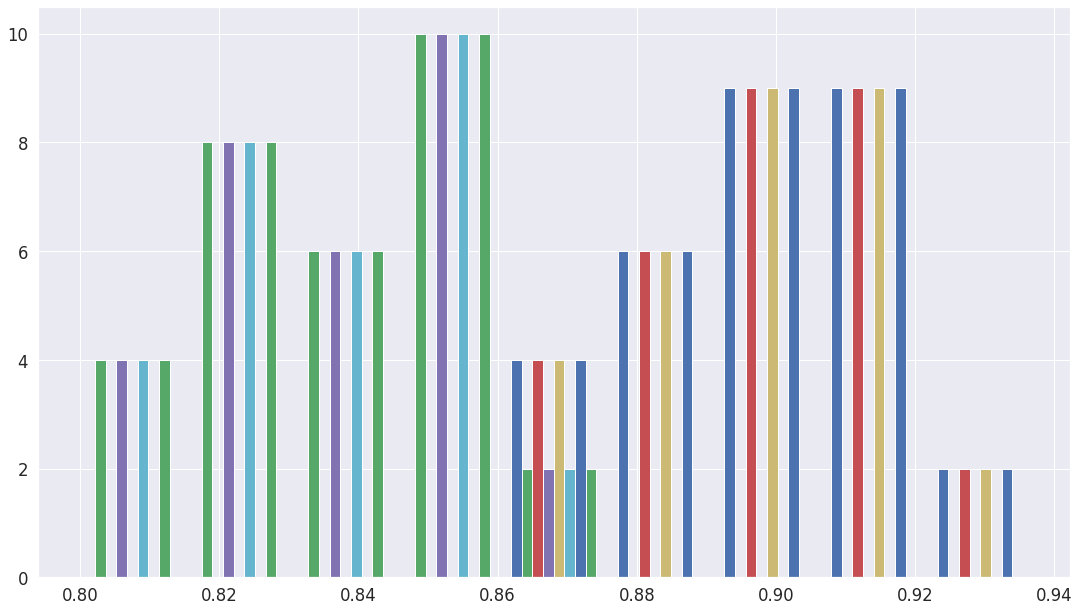

In [254]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)

x1 = grid_cnn_results['test_accuracy']
x2 = grid_rnn_results['test_accuracy']
x3 = grid_cnn_results['test_precision_samples']
x4 = grid_rnn_results['test_precision_samples']
x5 = grid_cnn_results['test_recall_samples']
x6 = grid_rnn_results['test_recall_samples']
x7 = grid_cnn_results['test_f1_samples']
x8 = grid_rnn_results['test_f1_samples']

n_bins = "auto"
x_multi = [x1,x2,x3,x4,x5,x6,x7,x8]
plt.hist(x_multi, n_bins, histtype='bar')
plt.show()